In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

In [2]:
!nvidia-smi

Sun May  7 23:38:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:01:00.0  On |                  N/A |
| 78%   60C    P0              159W / 350W|    667MiB / 24576MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load GoEmotions and General Audio Datasets (CREMA, TESS,  RAVDASS, ETC)

In [3]:
train_audio = pkl.load(open('./data/c4ai_clip/train_audio.pkl', "rb"))[['path', 'label']]
test_audio = pkl.load(open('./data/c4ai_clip/test_audio.pkl', "rb"))[['path', 'label']]
train_text = pkl.load(open('./data/c4ai_clip/train_text.pkl', "rb"))[['text', 'grouped_label']]
test_text = pkl.load(open('./data/c4ai_clip/test_text.pkl', "rb"))[['text', 'grouped_label']]

In [4]:
train_text = pd.concat([train_text, test_text])

In [5]:
#!unzip ./data/c4ai_clip/audio_emo_resampled.zip -d ./audio

In [6]:
def norm_labels(x):
    if x == "afraid":
        return "fear"
    elif x == "angry":
        return "anger"
    elif x == "disgusted":
        return "disgust"
    elif x == "sad":
        return "sadness"
    else:
        return x

In [7]:
train_audio["label"] = train_audio["label"].apply(norm_labels)
test_audio["label"] = test_audio["label"].apply(norm_labels)

In [8]:
test_audio

,path,label
11545,./audio/audio_emo/crema.man.sad.465.wav,sadness
1970,./audio/audio_emo/ravdass.man.sad.74.wav,sadness
6326,./audio/audio_emo/tess.woman.surprised.370.wav,surprise
11579,./audio/audio_emo/tess.woman.neutral.110.wav,neutral
9502,./audio/audio_emo/crema.woman.happy.586.wav,joy
...,...,...
8732,./audio/audio_emo/crema.man.angry.530.wav,anger
5386,./audio/audio_emo/tess.woman.happy.322.wav,joy
83,./audio/audio_emo/crema.man.afraid.455.wav,fear
6755,./audio/audio_emo/crema.woman.disgusted.239.wav,disgust


## Load Meld

In [9]:
def load_split_meld(split):
    assert split in ['train', 'test', 'dev']
    
    df = pd.read_csv(f"./meld_raw/{split}_splits/{split}_sent_emo.csv")
    df['path'] = df.apply(lambda x: f"./meld_raw/{split}_splits/audios/dia{x['Dialogue_ID']}_utt{x['Utterance_ID']}.wav".strip('\n'), axis=1)
    
    return (
        df[['path', 'Emotion', 'Utterance']]
        .rename(columns={'Emotion':'label', 'Utterance':'text'})
    )

In [10]:
df_meld_train = load_split_meld('train')
df_meld_dev = load_split_meld('dev')
df_meld_test = load_split_meld('test')

In [11]:
df_meld_dev[df_meld_dev['path'] == './meld_raw/dev_splits/audios/dia4_utt2.wav']

,path,label,text
29,./meld_raw/dev_splits/audios/dia4_utt2.wav,surprise,"Oh-oh, youre-youre fellow scholars."


In [12]:
df_meld_dev

,path,label,text
0,./meld_raw/dev_splits/audios/dia0_utt0.wav,sadness,"Oh my God, hes lost it. Hes totally lost it."
1,./meld_raw/dev_splits/audios/dia0_utt1.wav,surprise,What?
2,./meld_raw/dev_splits/audios/dia1_utt0.wav,neutral,"Or! Or, we could go to the bank, close our acc..."
3,./meld_raw/dev_splits/audios/dia1_utt1.wav,joy,Youre a genius!
4,./meld_raw/dev_splits/audios/dia1_utt2.wav,sadness,"Aww, man, now we wont be bank buddies!"
...,...,...,...
1104,./meld_raw/dev_splits/audios/dia113_utt9.wav,sadness,No.
1105,./meld_raw/dev_splits/audios/dia113_utt10.wav,sadness,What? Oh my God! Im gonna miss you so much!
1106,./meld_raw/dev_splits/audios/dia113_utt11.wav,sadness,Im gonna miss you!
1107,./meld_raw/dev_splits/audios/dia113_utt12.wav,sadness,I mean its the end of an era!


## Load Iemocap

In [13]:
def load_iemocap(path):
    def normalize_labels(label):
        if label == 'neu':
            return 'neutral'
        elif label == 'sad' or label == 'fru':
            return 'sadness'
        elif label == 'fea':
            return 'fear'
        elif label == 'dis':
            return 'disgust'
        elif label == 'sur':
            return 'surprise'
        elif label == 'ang':
            return 'anger'
        elif label == 'hap' or label == 'exc':
            return 'joy'
        else:
            return 'xxx'
        
    df = pd.read_csv(f'{path}/df_iemocap.csv')[['wav_file', 'emotion']]
    df_trans = pd.read_csv(f'{path}/iemocapTrans.csv')[['titre', 'to_translate']]
    
    df = df.merge(df_trans.rename(columns={'titre':'wav_file', 'to_translate':'text'}), how='left', on='wav_file')
    
    df['label'] = df['emotion'].apply(normalize_labels)
    print(df['label'].unique())
    df = df[df['label'] != 'xxx']
    df = df[['text', 'wav_file', 'label']]
    df['wav_file'] = df['wav_file'].apply(lambda x: f"{path}/audios/{x}.wav")
    df['split'] = df['wav_file'].apply(lambda x: 'train' if not '05' in x.split('_')[0][:-1] else 'test')
    df = df.rename(columns={'wav_file':'path'})
    train, test = df[df['split'] == 'train'], df[df['split'] == 'test']
    return train, test

In [14]:
df_iemocap_train, df_iemocap_test = load_iemocap('.')

['neutral' 'xxx' 'sadness' 'anger' 'joy' 'surprise' 'fear' 'disgust']


In [15]:
df_iemocap_train['label'].unique()

array(['neutral', 'sadness', 'anger', 'joy', 'surprise', 'fear',
       'disgust'], dtype=object)

In [16]:
df_iemocap_train.columns

Index(['text', 'path', 'label', 'split'], dtype='object')

## Join datasets (audio)

In [17]:
from os.path import exists

In [18]:
df_train_audio = pd.concat([df_iemocap_train[['text', 'path', 'label']], df_meld_train, train_audio.assign(text=[None for _ in range(len(train_audio))]), test_audio.assign(text=[None for _ in range(len(test_audio))])], axis=0).reset_index(drop=True)

In [19]:
df_dev_audio = pd.concat([df_iemocap_test[['text', 'path', 'label']], df_meld_dev], axis=0).reset_index(drop=True)

In [20]:
len(df_train_audio)

27550

In [21]:
len(df_dev_audio)

2759

In [22]:
### There are missing files (I believe in meld)

In [23]:
aud = []
for f in df_train_audio["path"]:
    if f is None:
        continue
    if not exists(f):
        aud.append(f)
df_train_audio = df_train_audio[~df_train_audio['path'].isin(aud)]

In [24]:
aud = []
for f in df_dev_audio["path"]:
    if f is None:
        continue
    if not exists(f):
        aud.append(f)
df_dev_audio = df_dev_audio[~df_dev_audio['path'].isin(aud)]

In [25]:
len(df_train_audio)

27549

In [26]:
len(df_dev_audio)

2758

In [27]:
print(len(train_text), len(df_train_audio), len(test_text), len(df_dev_audio))


48837 27549 5427 2758


In [28]:
from sklearn.preprocessing import LabelEncoder

lab_encoder = LabelEncoder()
lab_encoder.fit(df_train_audio['label'].unique())

LabelEncoder()

In [29]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [30]:
import torch
import torch.nn as nn

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.2, contrast_mode='all',
                 base_temperature=0.2):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None, temperature=None, base_temperature=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        if temperature == None:
            temperature = self.temperature
        if base_temperature == None:
            base_temperature = self.base_temperature
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 1]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (temperature/base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [31]:
class EmbeddingPropagation(nn.Module):
    """Embedding Propagation"""
    def __init__(self, in_dim=2048, k=32, num_classes=7, eps=1e-8, keep_rate=0.8, alpha=0.1):
        super(EmbeddingPropagation, self).__init__()
        self.k = k
        self.keep_rate = keep_rate
        self.num_classes = num_classes
        #self.g_enc = nn.Sequential(nn.Linear(in_dim, graph_emb))
        self.sigma_enc = nn.Sequential(nn.Linear(in_dim, in_dim//4), nn.GELU(), nn.Linear(in_dim//4, 1))
        self.eps = eps
        self.alpha = nn.Parameter(torch.tensor([alpha]).cuda(0), requires_grad=True)
        #self.alpha = nn.Parameter(torch.tensor([alpha]), requires_grad=True)

    def graph_construction(self, inputs):
        # Get Graph Embeddings
        #emb_all = inputs
        N, d    = inputs.shape[0], inputs.shape[1]

        sigmas = self.sigma_enc(inputs)
        
        # Get adjacency matrix
        emb_all_sigma = inputs / (sigmas+self.eps) # N*d
        W = torch.cdist(emb_all_sigma, emb_all_sigma)
        W = torch.exp(-W/2)

        # Keep topk nodes for neighborhood
        _, indices = torch.topk(W, self.k + 1)
        
        # Drop diagonal
        indices = indices[:, 1:]
        
        # Construct Undirected Graph adjacency
        mask = torch.zeros_like(W)
        mask = mask.scatter(1, indices, 1)
        mask = ((mask+torch.t(mask))>0).type(torch.float32)      # union, kNN graph
        W = W * mask

        # Dropout edges
        if self.training == True and self.keep_rate < 1.0:
            dropout_mask = torch.rand(*W.shape, requires_grad=True).cuda() < self.keep_rate # Can go wrong if mask entirely zero
            #dropout_mask = torch.rand(*W.shape, requires_grad=True) < self.keep_rate
            W = W * dropout_mask
            
        # Graph Adjacency matrix normalization
        D = W.sum(0)
        D_sqrt_inv = torch.sqrt(1.0/(D+self.eps))
        D1 = torch.unsqueeze(D_sqrt_inv,1).repeat(1,N)
        D2 = torch.unsqueeze(D_sqrt_inv,0).repeat(N,1)
        S = D1*W*D2

        return S

    def forward(self, inputs):

        N = inputs.shape[0]

        S = self.graph_construction(inputs)
        inv = torch.inverse(torch.eye(N).cuda(0)-self.alpha*S + self.eps)
        x = torch.matmul(inv, inputs)
        #x = x / inv.sum(1).unsqueeze(dim=0)
        return x

In [32]:
from transformers import AutoTokenizer, AutoModel

class TextEncoder(nn.Module):

    def __init__(self, model_name, max_len):
        super(TextEncoder, self).__init__()

        self.max_len = max_len
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        _ = self.tokenizer.add_tokens(['[NAME]', '[RELIGION]'], special_tokens=True)
        self.encoder = AutoModel.from_pretrained(model_name)
        self.encoder.resize_token_embeddings(len(self.tokenizer))
        #self.encoder = text_enc
 
    def forward(self, sentences):

        x = self.tokenizer(sentences, padding='max_length', truncation=True, return_tensors='pt', max_length=self.max_len)
        x = {
            "input_ids":x["input_ids"].to(0),
            "attention_mask":x["attention_mask"].to(0)
        }
        x = self.encoder(**x)[0]
        x = x[:, 0, :]

        return x

In [33]:
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import numpy as np
from tqdm import tqdm

def load_audio(path):
    wavform, _ = torchaudio.load(path)
    output = torch.mean(wavform, dim=0)
    return np.array(output, dtype=float)

class AudioEncoder(nn.Module):
    '''
    model = Wav2Vec2ForSequenceClassification.from_pretrained("superb/wav2vec2-base-superb-er")
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")

    # compute attention masks and normalize the waveform if needed
    inputs = feature_extractor(dataset[:4]["speech"], sampling_rate=16000, padding=True, return_tensors="pt")

    logits = model(**inputs).logits
    '''
    def __init__(self, model_name):
        super(AudioEncoder, self).__init__()
        self.encoder = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
        self.feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
        self.audio_proj = nn.Sequential(nn.Linear(768, 1024), nn.GELU(), nn.Linear(1024, 1024))
        self.proj = nn.Linear(1024, 128)
 
    def forward(self, audio_paths):
        
        audios = list(map(load_audio, audio_paths))
        
        inputs = self.feature_extractor(audios, sampling_rate=16000, padding=True, return_tensors="pt")
        
        input_values = inputs["input_values"].to(0)
        x = torch.mean(self.encoder(input_values=input_values).hidden_states[-1], dim=1)
        x = F.normalize(self.audio_proj(x), dim=-1)
        x = F.normalize(self.proj(x), dim=-1)
        return x

## MFCC Extractor and KMeans Hidden units

In [34]:
import torch
import librosa
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torchaudio
import numpy as np
from tqdm import tqdm
import functools
import math

def get_feats(x, sr):
    #x = torch.from_numpy(x).float()
    x = x.view(1, -1)

    mfccs = torchaudio.compliance.kaldi.mfcc(
        waveform=x,
        sample_frequency=sr,
        use_energy=True,
        #subtract_mean=True,
        #dither=1.
    )  # (time, freq)
    mfccs = mfccs.transpose(0, 1)  # (freq, time)
    deltas = torchaudio.functional.compute_deltas(mfccs)
    ddeltas = torchaudio.functional.compute_deltas(deltas)
    concat = torch.cat([mfccs, deltas, ddeltas], dim=0)
    concat = concat.transpose(0, 1).contiguous()  
    return concat

def mfcc_feature_extractor(path, desired_sr=16000):
    with torch.no_grad():
        waveform, sample_rate = torchaudio.load(path, normalize=True, channels_first=True)
        waveform = waveform.float()
        #print(waveform)
        if len(waveform.shape) == 2:
            waveform = torch.mean(waveform, dim=0).unsqueeze(dim=0)

        if sample_rate != desired_sr:
            transform = torchaudio.transforms.Resample(sample_rate, desired_sr)
            waveform = transform(waveform)

        mfcc = get_feats(waveform, desired_sr)
        return mfcc

In [35]:
def get_data_cluster(path):
    mfcc_audio = mfcc_feature_extractor(path)
    return mfcc_audio

In [36]:
get_data_cluster("./audio/audio_emo/tess.woman.sad.6.wav")

tensor([[  0.0000, -20.3169,   7.5364,  ...,   0.3019,  -1.0522,  -0.2722],
        [  0.0000, -19.8434,   6.8321,  ...,   0.6986,  -1.3757,   0.0576],
        [  0.0000, -21.2209,   6.7341,  ...,   1.5630,  -0.9881,   0.2393],
        ...,
        [  0.0000,  -9.6445,  -8.1216,  ...,  -0.6392,  -0.1196,  -0.8751],
        [  0.0000, -12.8456, -13.2523,  ...,  -0.9978,  -0.0610,  -0.9619],
        [  0.0000,  -8.9853,  -7.8230,  ...,  -0.2513,  -0.1463,  -0.7392]])

In [37]:
#X = torch.cat(list(map(get_data_cluster, df_train_audio["path"])), dim=0)

In [38]:
# np.subtract(mfcc_feat,np.mean(mfcc_feat))

In [39]:
mean = 0
std = 0

In [40]:
#X = (X - mean)/(std+1e-5)

In [41]:
#X.shape

In [42]:
from sklearn.cluster import MiniBatchKMeans
N_CLUSTERS = 100
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS,
                          random_state=0,
                          batch_size=300_000,
                          max_iter=1000000,
                          n_init=1,
                          init="k-means++") #.fit(X)


In [43]:
PATH_TO_SAVE = "./testando_a_tese_5"

In [44]:
!mkdir -p {PATH_TO_SAVE}

In [45]:
import pickle
#pickle.dump(kmeans, open(f"{PATH_TO_SAVE}/kmeans_{N_CLUSTERS}_clusters_curr.pkl", 'wb'))

## Add mask to Transformer, try learned positional embeddings

In [46]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class AudioEncoderMFCCHU(nn.Module):

    def __init__(self, 
                 clusterization_model, 
                 emb_size=N_CLUSTERS+1, 
                 pad_idx=N_CLUSTERS, 
                 emb_dim=768, 
                 n_layers=6, 
                 padd_trunk=300, 
                 nheads=8, 
                 dropout=0.1, 
                 cluster_data_mean=mean, 
                 cluster_data_std=std):
        super(AudioEncoderMFCCHU, self).__init__()
        
        self.cluster_data_mean = cluster_data_mean
        self.cluster_data_std = cluster_data_std
        self.clusterization_model = clusterization_model
        self.embedding = nn.Embedding(emb_size, emb_dim, max_norm=True, padding_idx=pad_idx)
        self.emb_size = emb_size
        self.padd_trunk = padd_trunk
        self.pad_idx = pad_idx
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)
        self.emb_dim = emb_dim
        
        self.transf_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nheads)
        self.transf_enc = nn.TransformerEncoder(self.transf_layer, num_layers=n_layers, norm=nn.LayerNorm(emb_dim))

    def preprocess_audio(self, path):
        mfcc = (mfcc_feature_extractor(path) - self.cluster_data_mean) / (self.cluster_data_std + 1e-10)
        token_ids = torch.Tensor(self.clusterization_model.predict(mfcc)).long().to(0)
        if len(token_ids) >= self.padd_trunk:
            token_ids = token_ids[:self.padd_trunk]
        else:
            repeat = torch.Tensor([self.pad_idx]*(self.padd_trunk-len(token_ids))).long().to(0)
            token_ids = torch.cat([token_ids,repeat], dim=0)
        
        return token_ids.unsqueeze(dim=0)

    def forward(self, audio_paths):
        
        with torch.no_grad():
            tokens = list(map(self.preprocess_audio, audio_paths))
            tks_tensor = torch.cat(tokens, axis=0) #.to(0)
            assert len(tks_tensor) == len(audio_paths)
        
        tks_tensor_lens = 1/torch.sum(tks_tensor != self.pad_idx, dim=-1)
        tks_tensor_lens = tks_tensor_lens.unsqueeze(dim=0).T

        emb = self.embedding(tks_tensor) * math.sqrt(self.emb_dim)
        emb = self.pos_encoder(emb)

        x = self.transf_enc(emb)
        x = tks_tensor_lens*torch.sum(x, dim=1)
        return x

In [47]:
class AudioTextCLIP(nn.Module):

    def __init__(self, 
                 text_encoder, 
                 audio_encoder, 
                 freeze_text_enc=False, 
                 freeze_audio_enc=False, 
                 in_features_text=384, 
                 in_features_audio=16, 
                 wide_proj=1024, 
                 proj_size=128, 
                 rate=0.1, 
                 hidden_size=384, 
                 num_classes=7, 
                 use_graph_aug=False, 
                 k=32):
        super(AudioTextCLIP, self).__init__()

        self.audio_encoder = audio_encoder
        self.text_encoder = text_encoder

        if freeze_text_enc:
            for i, (name, param) in enumerate(list(self.text_encoder.named_parameters())):
                param.requires_grad = False
        
        if freeze_audio_enc:
            for i, (name, param) in enumerate(list(self.audio_encoder.named_parameters())):
                param.requires_grad = False

        self.use_graph_aug = use_graph_aug
        if use_graph_aug:
            self.graph_enc = EmbeddingPropagation(in_dim=proj_size, k=k)
        
        self.mods_proj = nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.GELU(), nn.Dropout(p=rate), nn.Linear(hidden_size, wide_proj))
        #self.mods_proj = nn.Linear(hidden_size, wide_proj)
        
        self.text_proj = nn.Sequential(self.text_encoder, nn.Linear(in_features_text, hidden_size),  nn.GELU(), nn.Dropout(p=rate), nn.Linear(hidden_size, hidden_size), nn.GELU(), self.mods_proj)
        self.audio_proj = nn.Sequential(self.audio_encoder, nn.Linear(in_features_audio, hidden_size), nn.GELU(), nn.Dropout(p=rate), nn.Linear(hidden_size, hidden_size), nn.GELU(), self.mods_proj)
        
        #self.linear1 = nn.Linear(hidden_size, wide_proj)
        self.linear1 = lambda x: x
        #self.linear2 = nn.Sequential(nn.Linear(wide_proj, wide_proj), nn.GELU(), nn.Linear(wide_proj, proj_size))
        self.linear2 = nn.Linear(wide_proj, proj_size)
        self.rate = rate
        
    def forward(self, inp):

        sentences, audio_paths, multimodal = inp
        
        assert sentences != None or audio_paths != None or multimodal != None
        
        x_text = None
        x_text_wide = None
        if sentences != None:
            x_text = self.text_proj(sentences)
            x_text_wide = F.normalize(self.linear1(x_text), dim=-1)
            x_text = F.normalize(self.linear2(x_text_wide), dim=-1)
            
        x_audio = None
        x_audio_wide = None
        if audio_paths != None:
            x_audio = self.audio_proj(audio_paths)
            x_audio_wide = F.normalize(self.linear1(x_audio), dim=-1)
            x_audio = F.normalize(self.linear2(x_audio_wide), dim=-1)
        
        x_mult_text = None
        x_mult_text_wide = None
        x_mult_audio = None
        x_mult_audio_wide = None
        
        # Approximate text and audio, and make sum of vectors point to correct cls
        if multimodal != None:
            x_mult_text = self.text_proj([m['sentence'] for m in multimodal])
            x_mult_audio = self.audio_proj([m['audio_path'] for m in multimodal])
            
            # View 1
            x_mult_text_wide = F.normalize(self.linear1(F.dropout(x_mult_text, p=self.rate, training=self.training)), dim=-1)
            x_mult_text = F.normalize(self.linear2(x_mult_text_wide), dim=-1)
            
            # View 2
            x_mult_audio_wide = F.normalize(self.linear1(F.dropout(x_mult_audio, p=self.rate, training=self.training)), dim=-1)
            x_mult_audio = F.normalize(self.linear2(x_mult_audio_wide), dim=-1)

        # Graph contrast
        #if self.use_graph_aug:
        #    x2 = self.graph_enc(x2)
        #    x2 = F.normalize(x2, dim=-1)
            
        return {
            "x_text": x_text,
            "x_text_wide": x_text_wide,
            "x_audio": x_audio,
            "x_audio_wide": x_audio_wide,
            "x_mult_text": x_mult_text,
            "x_mult_text_wide": x_mult_text_wide,
            "x_mult_audio": x_mult_audio,
            "x_mult_audio_wide": x_mult_audio_wide,
        }

In [48]:
print(len(train_text), len(df_train_audio), len(test_text), len(df_dev_audio))

48837 27549 5427 2758


In [49]:
df_train_audio['label'].unique()

array(['neutral', 'sadness', 'anger', 'joy', 'surprise', 'fear',
       'disgust'], dtype=object)

In [50]:
train_audio_repeated = pd.concat([df_train_audio, df_train_audio], axis=0).sample(frac=1.0).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio,df_dev_audio], axis=0).sample(frac=1.0).reset_index(drop=True)

train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(train_text)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=768, shuffle=True)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_dev_audio)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False)

In [51]:
df_dev_audio

,text,path,label
0,"Hi, I need an ID.",./audios/Ses05F_impro01_F000.wav,neutral
1,"Okay, I'm sorry, but I just stood in this lin...",./audios/Ses05F_impro01_F001.wav,sadness
2,"No, they told me-I'm sorry, but they told me ...",./audios/Ses05F_impro01_F002.wav,sadness
3,"What, I mean what... what's the difference? ...",./audios/Ses05F_impro01_F003.wav,sadness
4,Can you just-can I just get the right-,./audios/Ses05F_impro01_F004.wav,sadness
...,...,...,...
2754,No.,./meld_raw/dev_splits/audios/dia113_utt9.wav,sadness
2755,What? Oh my God! Im gonna miss you so much!,./meld_raw/dev_splits/audios/dia113_utt10.wav,sadness
2756,Im gonna miss you!,./meld_raw/dev_splits/audios/dia113_utt11.wav,sadness
2757,I mean its the end of an era!,./meld_raw/dev_splits/audios/dia113_utt12.wav,sadness


In [52]:
df_dev_audio.iloc[len(df_iemocap_test):]["label"].unique()

array(['sadness', 'surprise', 'neutral', 'joy', 'anger', 'disgust',
       'fear'], dtype=object)

In [53]:
df_dev_audio["label"].unique()

array(['neutral', 'sadness', 'anger', 'fear', 'surprise', 'joy',
       'disgust'], dtype=object)

In [54]:
import torchaudio
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
gc.enable()

In [55]:
gc.collect()
#!pip install faiss-cpu --no-cache

0

In [56]:
#!sudo apt install libomp-dev

In [57]:
import numpy as np
import faiss


class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

In [58]:
#torch.cuda.empty_cache()
#opt.zero_grad(set_to_none=True)
#del opt
gc.collect()
#del supcon_model

0

In [59]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class Scheduler(_LRScheduler):
    def __init__(self, 
                 optimizer: Optimizer,
                 dim_embed: int,
                 warmup_steps: int,
                 last_epoch: int=-1,
                 verbose: bool=False) -> None:

        self.dim_embed = dim_embed
        self.warmup_steps = warmup_steps
        self.num_param_groups = len(optimizer.param_groups)

        super().__init__(optimizer, last_epoch, verbose)
        
    def get_lr(self) -> float:
        lr = calc_lr(self._step_count, self.dim_embed, self.warmup_steps)
        return [lr] * self.num_param_groups


def calc_lr(step, dim_embed, warmup_steps):
    #if step > warmup_steps:
    #    return 5e-5
    return dim_embed**(-0.5) * min(step**(-0.5), step * warmup_steps**(-1.5))

In [60]:
#audio_encoder = AudioEncoderMFCCHU(kmeans, emb_dim=768, n_layers=1, nheads=12)
audio_encoder = torch.load(f'audio_encoder_pre_trained_2/audio_encoder_best.bin')
audio_encoder.clusterization_model = pickle.load(open(f"audio_encoder_pre_trained_2/kmeans_128_clusters_curr.pkl", 'rb'))

In [61]:
#audio_encoder = AudioEncoderMFCCHU(kmeans, emb_dim=768, n_layers=1, nheads=12)
text_encoder = torch.load(f'pre_trained_text_encoder_2/text_encoder_best.bin')
text_encoder

TextEncoder(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 384)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      

In [62]:
gc.collect()

18

100%|█████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.58s/it]


Cosine Similarity between mods: 0.8303541608095342
General - KNN F1: 0.4898734183383813 Acc: 0.495286439448876
Iemocap - KNN F1: 0.4716196867653834 Acc: 0.5024242424242424
Meld - KNN F1: 0.46742513660761237 Acc: 0.48465703971119134


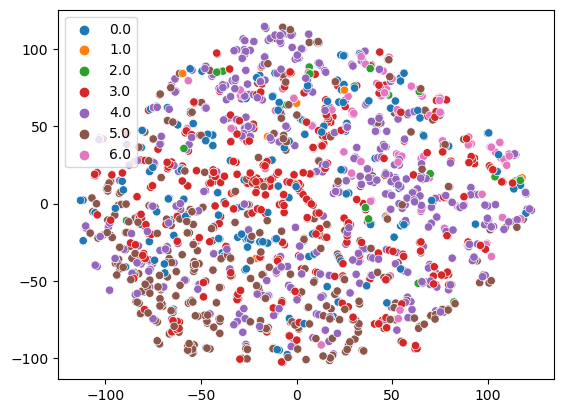

Epoch: 1 - Train Loss: 13.846225589513779


100%|█████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]


Cosine Similarity between mods: 0.8115738888768894
General - KNN F1: 0.5114570129497371 Acc: 0.5228426395939086
Iemocap - KNN F1: 0.47984253304017466 Acc: 0.5072727272727273
Meld - KNN F1: 0.5066803598977636 Acc: 0.546028880866426


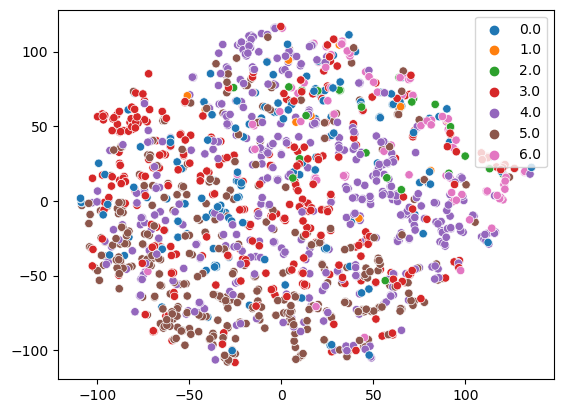

Epoch: 2 - Train Loss: 13.676899299025536


100%|█████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.63s/it]


Cosine Similarity between mods: 0.7904401340719753
General - KNN F1: 0.5166373871824204 Acc: 0.5261058738216099
Iemocap - KNN F1: 0.48704174949019013 Acc: 0.5066666666666667
Meld - KNN F1: 0.5099321268221659 Acc: 0.5550541516245487


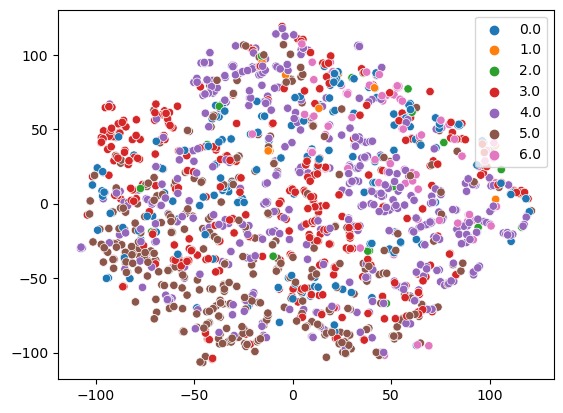

Epoch: 3 - Train Loss: 13.603424534201622


100%|█████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]


Cosine Similarity between mods: 0.7743965906885935
General - KNN F1: 0.5236851419014792 Acc: 0.5351704133430022
Iemocap - KNN F1: 0.5057922763622612 Acc: 0.516969696969697
Meld - KNN F1: 0.5132763243008444 Acc: 0.5622743682310469


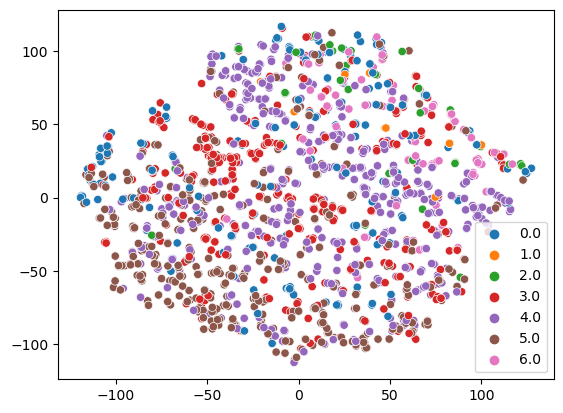

Epoch: 4 - Train Loss: 13.552249893546104


100%|█████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.57s/it]


Cosine Similarity between mods: 0.7552859864432021
General - KNN F1: 0.5324224497477902 Acc: 0.5449601160261058
Iemocap - KNN F1: 0.5198928411914823 Acc: 0.5309090909090909
Meld - KNN F1: 0.5213060412507682 Acc: 0.5658844765342961


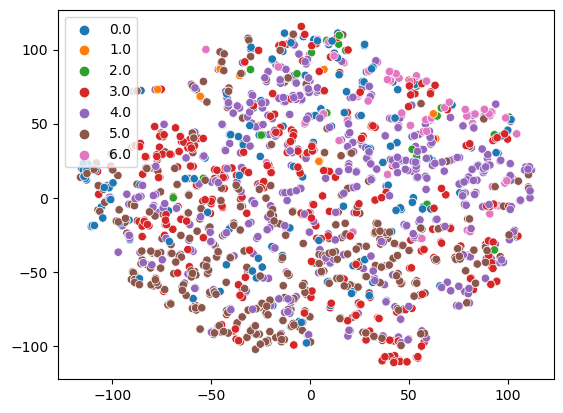

Epoch: 5 - Train Loss: 13.509313762187958


100%|█████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Cosine Similarity between mods: 0.733103673988879
General - KNN F1: 0.5323673635342887 Acc: 0.5442349528643945
Iemocap - KNN F1: 0.5265609920942563 Acc: 0.5357575757575758
Meld - KNN F1: 0.5077980614418757 Acc: 0.5568592057761733


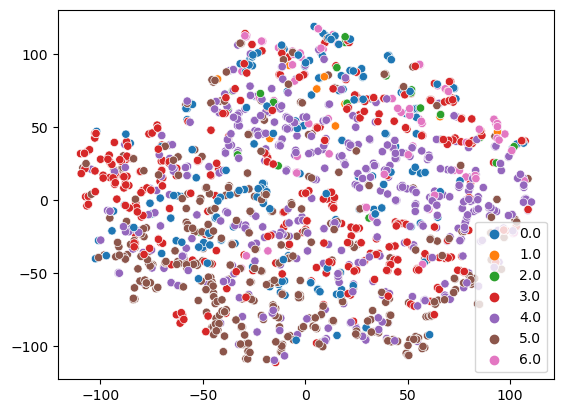

Epoch: 6 - Train Loss: 13.472107857465744


 33%|████████████████████▎                                        | 2/6 [00:05<00:11,  2.89s/it]

In [ ]:
dim_embed=1024

supcon_model = AudioTextCLIP(
    text_encoder,
    audio_encoder,
    in_features_text=384,
    in_features_audio=dim_embed, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    use_graph_aug=False,                   
    freeze_text_enc=False,
    freeze_audio_enc=False,
    k=32,
)

supcon_loss = SupConLoss(temperature=0.1, contrast_mode='all', base_temperature=0.1)
supcon_loss_intra = SupConLoss(temperature=0.3, contrast_mode='all', base_temperature=0.3)

supcon_model.to(0)

#supcon_model = torch.compile(supcon_model)
scaler = torch.cuda.amp.GradScaler()

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')

param_optimizer = list(supcon_model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.1
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

opt = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-5, betas=(0.9, 0.98), eps=1e-8)

warmup_steps=600

#scheduler = Scheduler(opt,dim_embed,warmup_steps)
epochs = 9999
nb_steps = 20

#supcon_model.load_state_dict(torch.load(f'testando_a_tese_4_BEST/pytorch_model_AudioTextCLIP_epoch_30.bin')['model'])
#scaler.load_state_dict(torch.load(f'testando_a_tese_4_BEST/pytorch_model_AudioTextCLIP_epoch_30.bin')['scaler'])
#opt.load_state_dict(torch.load(f'testando_a_tese_4_BEST/pytorch_model_AudioTextCLIP_epoch_30.bin')['optimizer'])

while e < epochs:
    supcon_model.train()
    epoch_loss = 0.0
    proj_val = []
    targets_val = []

    proj_train = []
    targets_train = []

    for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):

        sentences = list(train_text.iloc[batch_indices[0]]["text"])

        multimodal_or_audio = train_audio_repeated.iloc[batch_indices[0]]
        multimodal_df = multimodal_or_audio[~multimodal_or_audio['text'].isna()]
        multimodal = [{'sentence': str(t['text']), 'audio_path':str(t['path'])} for _, t in multimodal_df.iterrows()]
        audio_df = multimodal_or_audio[multimodal_or_audio['text'].isna()]
        audio_paths = list(audio_df["path"])
        
        y_text, y_audio, y_mult = torch.Tensor(lab_encoder.transform(list(train_text.iloc[batch_indices[0]]["grouped_label"]))), torch.Tensor(lab_encoder.transform(list(audio_df["label"]))), torch.Tensor(lab_encoder.transform(list(multimodal_df["label"])))

        target = torch.cat([y_text, y_audio, y_mult])
        
        x = [sentences, audio_paths, multimodal]
        for k, val in enumerate(x):
            if len(val) == 0:
                x[k] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            
            out = supcon_model(x)
            
            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                x_mult = F.normalize(x_mult_text + x_mult_audio, dim=-1)
                
                x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
                
                x_mult_text = x_mult_text.unsqueeze(dim=1)
                x_mult_audio = x_mult_audio.unsqueeze(dim=1)
                mult = torch.cat([x_mult_text, x_mult_audio], dim=1)
                
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide], dim=0)
                else:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_audio"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide], dim=0)
                        
                loss = supcon_loss(out_x, labels=target) + supcon_loss_intra(mult)
            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")
                        
                loss = supcon_loss(out_x, labels=target)

        scaler.scale(loss).backward()
        scaler.unscale_(opt)

        torch.nn.utils.clip_grad_norm_(supcon_model.parameters(), 20.0)
        #torch.nn.utils.clip_grad_norm_(supcon_model.text_encoder.parameters(), 0.1)
        scaler.step(opt)
        scaler.update()
        #scheduler.step()
        opt.zero_grad(set_to_none=True)

        epoch_loss += loss.item()
        proj_train.append(np.array(out_x_wide.detach().cpu()))
        targets_train.append(np.array(target.cpu()))

        del out_x
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()
        
    proj_train = np.concatenate(proj_train, axis=0)
    targets_train = np.concatenate(targets_train, axis=0)
    
    
    clf = FaissKNeighbors(k=128)
    clf.fit(proj_train, np.array(targets_train, dtype=int))

    epoch_loss = epoch_loss/len(train_loader)
    supcon_model.eval()
    preds = []
    targets = []
    css = 0.0
    
    for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
        with torch.no_grad():
        
            multimodal_or_audio = df_dev_audio.iloc[batch_indices[0]]
            multimodal_df = multimodal_or_audio[~multimodal_or_audio['text'].isna()]
            multimodal = [{'sentence': str(t['text']), 'audio_path':str(t['path'])} for _, t in multimodal_df.iterrows()]
            audio_df = multimodal_or_audio[multimodal_or_audio['text'].isna()]
            audio_paths = list(audio_df["path"])

            target = torch.Tensor(lab_encoder.transform(list(multimodal_df["label"])))

            x = [None, None, multimodal]
            with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
                out = supcon_model(x)
            
            # Multimodal loss
            out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)
            
            cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

            wide = np.array(out_x_wide.cpu())
            pred = clf.predict(wide)
            preds.append(pred)

            assert len(wide) == len(pred)

            proj_val.append(wide)
            targets_val.append(np.array(target.cpu()))
            css += np.sum(np.array(cs.cpu()))
            del out_x_wide
            gc.collect()
            torch.cuda.empty_cache()

    proj_val = np.concatenate(proj_val, axis=0)
    targets_val = np.concatenate(targets_val, axis=0)
    
    preds = np.array(np.concatenate(preds, axis=0))
    
    css = css / len(df_dev_audio)

    general_f1 = f1_score(targets_val, preds, average='weighted')
    general_acc = accuracy_score(targets_val, preds)
    
    general_f1_iemocap = f1_score(targets_val[:len(df_iemocap_test)], preds[:len(df_iemocap_test)], average='weighted')
    general_acc_iemocap = accuracy_score(targets_val[:len(df_iemocap_test)], preds[:len(df_iemocap_test)])
    
    general_f1_meld = f1_score(targets_val[len(df_iemocap_test):], preds[len(df_iemocap_test):], average='weighted')
    general_acc_meld = accuracy_score(targets_val[len(df_iemocap_test):], preds[len(df_iemocap_test):])
    
    print(f'Cosine Similarity between mods: {css}')
    print(f'General - KNN F1: {general_f1} Acc: {general_acc}')
    print(f'Iemocap - KNN F1: {general_f1_iemocap} Acc: {general_acc_iemocap}')
    print(f'Meld - KNN F1: {general_f1_meld} Acc: {general_acc_meld}')

    idx = np.random.randint(len(proj_val), size=2000)

    proj_val_samp = proj_val[idx, :]
    targets_val_samp = targets_val[idx]
    tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val_samp)

    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=targets_val_samp, palette='tab10')
    plt.show()

    print(f'Epoch: {e + 1} - Train Loss: {epoch_loss}')
    e += 1

    with open(f"{PATH_TO_SAVE}/metrics_epoch_{e}.txt", "w") as f:
        f.write(f'General - KNN F1 (weighted): {general_f1} Acc: {general_acc}')
        
    checkpoint = {"model": supcon_model.state_dict(),
              "optimizer": opt.state_dict(),
              "scaler": scaler.state_dict()}
    torch.save(checkpoint, f'{PATH_TO_SAVE}/pytorch_model_AudioTextCLIP_epoch_{e}.bin')

In [ ]:
proj_val.shape

In [ ]:
PATH_TO_SAVE

In [ ]:
xxx

In [ ]:
'''
Text - KNN F1: 0.6542348387913128 Acc: 0.6550580431177446
Audio - KNN F1: 0.5737952249753031 Acc: 0.5750875253362816
General - KNN F1: 0.6162479641396962 Acc: 0.6150727842270131

Epoch: 58 - Train Loss: 6.735767356136389

torch.save(checkpoint, f'./transformer_1_layer_repetindo/pytorch_model_AudioTextCLIPvFinal_epoch_{e}_only_meld.bin')
'''

## Eval

In [ ]:
#import pickle
#pickle.dump(kmeans, open("./transformer_1_layer_repetindo/kmeans_200_clusters_curr.pkl", 'wb'))

In [ ]:
gc.collect()

In [ ]:
PATH_TO_SAVE

In [ ]:
supcon_model = AudioTextCLIP(
    text_encoder,
    audio_encoder,
    in_features_text=384,
    in_features_audio=1024, 
    hidden_size=1024,
    wide_proj=2048,
    proj_size=128, 
    use_graph_aug=False,                   
    freeze_text_enc=True, 
    freeze_audio_enc=False,
    k=32,
)


supcon_model.to(0)

supcon_model.load_state_dict(torch.load(f'testando_a_tese_5/pytorch_model_AudioTextCLIP_epoch_9.bin')['model'])

In [ ]:
supcon_model.audio_encoder.clusterization_model = pickle.load(open(f"audio_encoder_pre_trained_2/kmeans_128_clusters_curr.pkl", 'rb'))

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
get_n_params(supcon_model)

In [ ]:
supcon_model.eval()

In [ ]:
import pickle

In [ ]:
supcon_model.audio_encoder.clusterization_model = pickle.load(open(f"audio_encoder_pre_trained/kmeans_100_clusters_curr.pkl", 'rb'))

In [ ]:
test = supcon_model([["I Hate you, i believe you are shit!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text_wide"][0, :], dim=0), F.normalize(test["x_text_wide"][1, :], dim=0))

In [ ]:
test = supcon_model([["The best man ever, keep the good work!", "you are my best friend, love you!"],None, None])
torch.dot(F.normalize(test["x_text"][0, :], dim=0), F.normalize(test["x_text"][1, :], dim=0))

In [ ]:
test = supcon_model([["I Hate you, i believe you are shit!", "you should not be alive"],None, None])
torch.dot(F.normalize(test["x_text"][0, :], dim=0), F.normalize(test["x_text"][1, :], dim=0))

In [ ]:
with torch.no_grad():
    test = supcon_model([["you are my best friend, love you!"],["./audio/audio_emo/tess.woman.sad.279.wav"], None])
    print(torch.dot(F.normalize(test["x_text"][0, :], dim=0), F.normalize(test["x_audio"][0, :], dim=0)))

In [ ]:
with torch.no_grad():
    test = supcon_model([["I am sad because my dog died"],["./audio/audio_emo/tess.woman.sad.279.wav"], None])
    print(torch.dot(F.normalize(test["x_text"][0, :], dim=0), F.normalize(test["x_audio"][0, :], dim=0)))

In [ ]:
with torch.no_grad():
    test = supcon_model([["you are my best friend, love you!"],["./audio/audio_emo/tess.woman.happy.50.wav"], None])
    print(torch.dot(F.normalize(test["x_text"][0, :], dim=0), F.normalize(test["x_audio"][0, :], dim=0)))

In [ ]:
with torch.no_grad():
    test = supcon_model([None,["./audio/audio_emo/tess.woman.happy.50.wav", "./audio/audio_emo/crema.man.happy157.wav"], None])
    print(torch.dot(F.normalize(test["x_audio"][0, :], dim=0), F.normalize(test["x_audio"][1, :], dim=0)))

In [ ]:
#supcon_model.load_state_dict(torch.load('./pytorch_model_AudioTextCLIPvFinal_epoch_25_only_meld.bin'))

In [ ]:
#supcon_model.audio_encoder.clusterization_model = kmeans

In [ ]:
gc.collect()

In [ ]:
df_train_audio = pd.concat([df_iemocap_train[['text', 'path', 'label']], df_meld_train, train_audio.assign(text=[None for _ in range(len(train_audio))])], axis=0).reset_index(drop=True)
#df_train_audio = df_meld_train

In [ ]:
#df_dev_audio = pd.concat([df_meld_dev, test_audio], axis=0)

# Param: Select dataset for scoring

In [ ]:
#df_dev_audio = df_iemocap_test[['text', 'path', 'label']] # Iemocap
#df_dev_audio = test_audio # Others (cremad, revss, tess)
df_dev_audio = df_meld_test # Meld

In [ ]:
len(df_train_audio)

In [ ]:
len(df_dev_audio)

In [ ]:
aud = []
for f in df_train_audio["path"]:
    if not exists(f):
        aud.append(f)
df_train_audio = df_train_audio[~df_train_audio['path'].isin(aud)]

In [ ]:
aud = []
for f in df_dev_audio["path"]:
    if not exists(f):
        aud.append(f)
df_dev_audio = df_dev_audio[~df_dev_audio['path'].isin(aud)]

In [ ]:
len(df_dev_audio)

In [ ]:
#train_audio_repeated = pd.concat([df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio, df_train_audio,df_train_audio,df_train_audio,df_train_audio,df_train_audio], axis=0).sample(frac=1).reset_index(drop=True)
#test_audio_repeated = pd.concat([df_dev_audio, df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio,df_dev_audio], axis=0).sample(frac=1).reset_index(drop=True)

train_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_train_audio)))))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.Tensor(list(range(len(df_dev_audio)))))
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)

In [ ]:
gc.collect()

In [ ]:
#supcon_model = torch.compile(supcon_model)

step = 0
e = 0
patience = 9999
early_stop_flag = 0
old_f1 = -float('inf')


#supcon_model.load_state_dict(torch.load(f'testando_a_tese_4_BEST/pytorch_model_AudioTextCLIP_epoch_30.bin')['model'])
#scaler.load_state_dict(torch.load(f'testando_a_tese_4_BEST/pytorch_model_AudioTextCLIP_epoch_30.bin')['scaler'])
#opt.load_state_dict(torch.load(f'testando_a_tese_4_BEST/pytorch_model_AudioTextCLIP_epoch_30.bin')['optimizer'])

supcon_model.eval()
epoch_loss = 0.0
proj_val = []
targets_val = []

proj_train = []
targets_train = []

for i, batch_indices in enumerate(tqdm(train_loader, total=len(train_loader))):

    with torch.no_grad():

        sentences = list(train_text.iloc[batch_indices[0]]["text"])

        multimodal_or_audio = train_audio_repeated.iloc[batch_indices[0]]
        multimodal_df = multimodal_or_audio[~multimodal_or_audio['text'].isna()]
        multimodal = [{'sentence': str(t['text']), 'audio_path':str(t['path'])} for _, t in multimodal_df.iterrows()]
        audio_df = multimodal_or_audio[multimodal_or_audio['text'].isna()]
        audio_paths = list(audio_df["path"])

        y_text, y_audio, y_mult = torch.Tensor(lab_encoder.transform(list(train_text.iloc[batch_indices[0]]["grouped_label"]))), torch.Tensor(lab_encoder.transform(list(audio_df["label"]))), torch.Tensor(lab_encoder.transform(list(multimodal_df["label"])))

        target = torch.cat([y_text, y_audio, y_mult])

        x = [sentences, audio_paths, multimodal]
        for k, val in enumerate(x):
            if len(val) == 0:
                x[k] = None

        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:

            out = supcon_model(x)

            # Multimodal loss
            if x[-1] is not None:
                x_mult_text = out["x_mult_text"]
                x_mult_audio = out["x_mult_audio"]
                x_mult = F.normalize(x_mult_text + x_mult_audio, dim=-1)

                x_mult_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)

                x_mult_text = x_mult_text.unsqueeze(dim=1)
                x_mult_audio = x_mult_audio.unsqueeze(dim=1)
                mult = torch.cat([x_mult_text, x_mult_audio], dim=1)

                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"], x_mult_wide], dim=0)
                    else:
                        out_x = torch.cat([out["x_text"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], x_mult_wide], dim=0)
                else:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_audio"], x_mult], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_audio_wide"], x_mult_wide], dim=0)

            else:
                if x[0] is not None:
                    if x[1] is not None:
                        out_x = torch.cat([out["x_text"], out["x_audio"]], dim=0).unsqueeze(dim=1)
                        out_x_wide = torch.cat([out["x_text_wide"], out["x_audio_wide"]], dim=0)
                    else:
                        out_x = out["x_text"]
                        out_x_wide = out["x_text_wide"]
                else:
                    if x[1] is not None:
                        out_x = out["x_audio"]
                        out_x_wide = out["x_audio_wide"]
                    else:
                        raise Exception("Nothing to work :()")


    proj_train.append(np.array(out_x_wide.detach().cpu()))
    targets_train.append(np.array(target.cpu()))

    del out_x
    del out_x_wide
    gc.collect()
    torch.cuda.empty_cache()

proj_train = np.concatenate(proj_train, axis=0)
targets_train = np.concatenate(targets_train, axis=0)


clf = FaissKNeighbors(k=128)
clf.fit(proj_train, np.array(targets_train, dtype=int))



In [ ]:
preds = []
targets = []
css = 0.0
proj_val = []
targets_val = []
for i, batch_indices in enumerate(tqdm(test_loader, total=len(test_loader))):
    with torch.no_grad():

        multimodal_or_audio = df_dev_audio.iloc[batch_indices[0]]
        multimodal_df = multimodal_or_audio[~multimodal_or_audio['text'].isna()]
        multimodal = [{'sentence': str(t['text']), 'audio_path':str(t['path'])} for _, t in multimodal_df.iterrows()]
        audio_df = multimodal_or_audio[multimodal_or_audio['text'].isna()]
        audio_paths = list(audio_df["path"])

        target = torch.Tensor(lab_encoder.transform(list(multimodal_df["label"])))

        x = [None, None, multimodal]
        with torch.cuda.amp.autocast(enabled=True, dtype=torch.float16) as autocast, torch.backends.cuda.sdp_kernel(enable_flash=False) as disable:
            out = supcon_model(x)

        # Multimodal loss
        out_x_wide = F.normalize(out["x_mult_text_wide"] + out["x_mult_audio_wide"], dim=-1)

        cs = F.cosine_similarity(out["x_mult_text_wide"], out["x_mult_audio_wide"])

        wide = np.array(out_x_wide.cpu())
        pred = clf.predict(wide)
        preds.append(pred)

        assert len(wide) == len(pred)

        proj_val.append(wide)
        targets_val.append(np.array(target.cpu()))
        css += np.sum(np.array(cs.cpu()))
        del out_x_wide
        gc.collect()
        torch.cuda.empty_cache()

proj_val = np.concatenate(proj_val, axis=0)
targets_val = np.concatenate(targets_val, axis=0)
preds = np.array(np.concatenate(preds, axis=0))
css = css / len(df_dev_audio)

general_f1 = f1_score(targets_val, preds, average='weighted')
general_acc = accuracy_score(targets_val, preds)

print(f'Cosine Similarity between mods: {css}')
print(f'General - KNN F1: {general_f1} Acc: {general_acc}')

idx = np.random.randint(len(proj_val), size=2000)

proj_val_samp = proj_val[idx, :]
targets_val_samp = targets_val[idx]
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=5).fit_transform(proj_val_samp)

sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=targets_val_samp, palette='tab10')
plt.show()

In [ ]:
clf = FaissKNeighbors(k=32)
clf.fit(proj_train, np.array(targets_train, dtype=int))

In [ ]:
preds = clf.predict(emb_audio)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
mean_test = proj_train.mean(axis=0)
std_test = proj_train.std(axis=0)
clf = LogisticRegression()
clf.fit(proj_train, targets_train)

In [ ]:
proj_train

In [ ]:
proj_val.shape

In [ ]:
preds = clf.predict(proj_val)

In [ ]:
f1_score(targets_val, preds, average='weighted')

In [ ]:
accuracy_score(targets_val, preds)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(targets_val, preds))